In [ ]:
!unzip Lab4.zip -d /content/extracted/


Archive:  Lab4.zip
   creating: /content/extracted/Lab 4/
   creating: /content/extracted/Lab 4/.ipynb_checkpoints/
   creating: /content/extracted/Lab 4/font/
  inflating: /content/extracted/Lab 4/font/FiraMono-Medium.otf  
  inflating: /content/extracted/Lab 4/font/SIL+Open+Font+License.txt  
   creating: /content/extracted/Lab 4/images/
  inflating: /content/extracted/Lab 4/images/0100.jpg  
  inflating: /content/extracted/Lab 4/images/0101.jpg  
  inflating: /content/extracted/Lab 4/images/0102.jpg  
  inflating: /content/extracted/Lab 4/images/0103.jpg  
  inflating: /content/extracted/Lab 4/images/0104.jpg  
  inflating: /content/extracted/Lab 4/images/0105.jpg  
  inflating: /content/extracted/Lab 4/images/0106.jpg  
  inflating: /content/extracted/Lab 4/images/0107.jpg  
  inflating: /content/extracted/Lab 4/images/0108.jpg  
  inflating: /content/extracted/Lab 4/images/0109.jpg  
  inflating: /content/extracted/Lab 4/images/0110.jpg  
  inflating: /content/extracted/Lab 4/imag

In [ ]:
!pip -q install --upgrade ultralytics opencv-python pillow matplotlib

import os, glob
import numpy as np
from typing import Tuple
from PIL import Image, ImageDraw
import tensorflow as tf
import matplotlib.pyplot as plt

print("TensorFlow:", tf.__version__)
print("Eager execution:", tf.executing_eagerly())

TensorFlow: 2.19.0
Eager execution: True


In [ ]:
import sys

sys.path.insert(0, "extracted/Lab4")
import yolo_utils

In [ ]:
from ultralytics import YOLO

# Load a small pretrained pytorch model
model = YOLO("yolov8n.pt")
print("Loaded YOLOv8 model")

def run_yolov8(image_path, score_threshold=0.25, iou_threshold=0.45):
    results = model.predict(image_path, conf=score_threshold, iou=iou_threshold, verbose=False)
    if not results or results[0].boxes is None:
        return np.zeros((0,4), np.float32), np.zeros((0,), np.float32), np.zeros((0,), np.int32)
    r = results[0]
    xyxy = r.boxes.xyxy.cpu().numpy().astype(np.float32)  # (x1,y1,x2,y2)
    conf = r.boxes.conf.cpu().numpy().astype(np.float32)
    cls  = r.boxes.cls.cpu().numpy().astype(np.int32)
    yx = xyxy[:, [1,0,3,2]]  # → (y1,x1,y2,x2)
    return yx, conf, cls

Loaded YOLOv8 model


In [ ]:
from PIL import ImageDraw, ImageFont

from PIL import ImageDraw, ImageFont

def draw_boxes(image_path, boxes, scores, classes,
               class_names=None, wanted_idx=None,
               min_score=0.25, font_path="font/arial.ttf",
               save_back=False, suffix="_detected"):
    """
    Draw boxes on image, optionally overwrite/save back into images folder.
    """
    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype(font_path, 14)
    except:
        font = None

    count = 0
    for b, s, c in zip(boxes, scores, classes):
        if s < min_score:
            continue
        if wanted_idx is not None and c != wanted_idx:
            continue
        y1, x1, y2, x2 = [int(v) for v in b]
        draw.rectangle([x1, y1, x2, y2], outline=(0,255,0), width=3)
        label = f"{class_names[c] if class_names else c}: {s:.2f}"
        draw.text((x1+3, max(0, y1-12)), label, fill=(255,255,0), font=font)
        count += 1

    # save back into same folder
    if save_back:
        base, ext = os.path.splitext(image_path)
        new_path = f"{base}{suffix}{ext}"   # e.g. 0114_detected.jpg
        img.save(new_path)
        print(f"Saved annotated image: {new_path}")
        return img, count, new_path

    return img, count


In [ ]:
# Multi classes detection
import os
from PIL import Image, ImageDraw, ImageFont

def draw_boxes(image_path, boxes, scores, classes,
               class_names=None, wanted_idx=None,
               min_score=0.45, font_path="font/arial.ttf",
               save_back=False, suffix="_detected"):
    """
    Draw boxes on image, optionally overwrite/save back into images folder.
    Supports filtering by multiple classes.
    """
    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype(font_path, 14)
    except:
        font = None

    count = 0
    for b, s, c in zip(boxes, scores, classes):
        if s < min_score:
            continue
        # if wanted_idx is a list, keep only those classes
        if wanted_idx is not None:
            if isinstance(wanted_idx, (list, tuple, set)):
                if c not in wanted_idx:
                    continue
            else:
                if c != wanted_idx:
                    continue

        y1, x1, y2, x2 = [int(v) for v in b]
        draw.rectangle([x1, y1, x2, y2], outline=(0,255,0), width=3)
        label = f"{class_names[c] if class_names else c}: {s:.2f}"
        draw.text((x1+3, max(0, y1-12)), label, fill=(255,255,0), font=font)
        count += 1

    # save back into same folder
    if save_back:
        base, ext = os.path.splitext(image_path)
        new_path = f"{base}{suffix}{ext}"   # e.g. 0114_detected.jpg
        img.save(new_path)
        print(f"Saved annotated image: {new_path}")
        return img, count, new_path

    return img, count

In [ ]:
def postprocess_with_tf2(image_path, score_threshold=0.25, iou_threshold=0.6, max_boxes=50, wanted_class="car"):
    # Get YOLOv8 raw detections
    yx_boxes, conf, cls = run_yolov8(image_path, score_threshold=0.0, iou_threshold=0.7)
    if yx_boxes.shape[0] == 0:
        return np.zeros((0,), np.float32), np.zeros((0,4), np.float32), np.zeros((0,), np.int32)

    N, C = yx_boxes.shape[0], len(class_names)
    box_conf = tf.convert_to_tensor(conf.reshape(1, N, 1), dtype=tf.float32)
    boxes    = tf.convert_to_tensor(yx_boxes.reshape(1, N, 4), dtype=tf.float32)

    # One-hot class probabilities
    probs = np.zeros((1, N, C), dtype=np.float32)
    for i, c in enumerate(cls):
        if 0 <= c < C:
            probs[0, i, c] = 1.0
    box_probs = tf.convert_to_tensor(probs, dtype=tf.float32)

    with Image.open(image_path) as im:
        H, W = im.height, im.width

    scores, fboxes, classes = yolo_eval(
        box_conf, boxes, box_probs,
        image_shape=(H, W),
        max_boxes=max_boxes,
        score_threshold=score_threshold,
        iou_threshold=iou_threshold,
        per_class_nms=True
    )

    # Optionally filter wanted class
    if wanted_class in class_names:
        idx = class_names.index(wanted_class)
        mask = tf.where(classes == idx)[:,0]
        scores = tf.gather(scores, mask)
        fboxes = tf.gather(fboxes, mask)
        classes = tf.gather(classes, mask)

    return scores.numpy(), fboxes.numpy(), classes.numpy()


In [ ]:
# Load class names from model_data
class_file = "extracted/Lab4/model_data/coco_classes.txt"   # adjust path if needed
anchors_path = "extracted/Lab4/model_data/yolo_anchors.txt"
class_names = yolo_utils.read_classes(class_file)
anchors = yolo_utils.read_anchors(anchors_path)

num_classes = len(class_names)
num_anchors = anchors.shape[0]

print("Loaded", len(class_names), "classes.")
print("Example:", class_names[:10])
print("Loaded", len(anchors), "anchors.")
print("Example:", anchors[:10])

Loaded 80 classes.
Example: ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light']
Loaded 5 anchors.
Example: [[    0.57273     0.67739]
 [     1.8745      2.0625]
 [     3.3384      5.4743]
 [     7.8828      3.5278]
 [     9.7705      9.1683]]


Cars detected (direct): 5


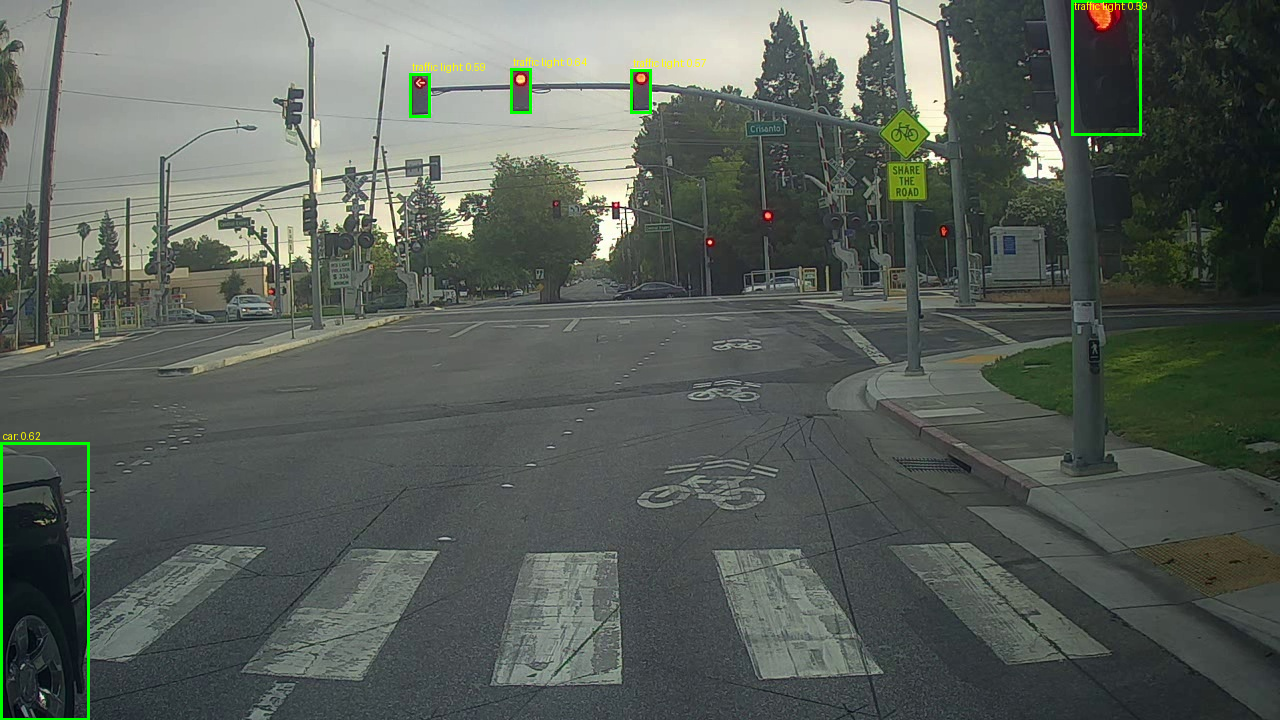

In [ ]:
image_path = "extracted/Lab4/images/0118.jpg"   # put your test road scene here
#image_path = "extracted/Lab4/images/0112.jpg"
# Direct YOLOv8
boxes, scores, classes = run_yolov8(image_path, score_threshold=0.45, iou_threshold=0.45)
vis, count = draw_boxes(image_path, boxes, scores, classes, class_names=class_names, wanted_idx=[class_names.index("truck"),class_names.index("car"),class_names.index("bus"),class_names.index("traffic light")])
print("Cars detected (direct):", count)
display(vis)



In [ ]:
def process_folder(folder="images", min_score=0.25, save_out=True):
    out_dir = "out"
    os.makedirs(out_dir, exist_ok=True)
    report = []
    for img_file in glob.glob(os.path.join(folder, "*.*")):
        try:
            boxes, scores, classes = run_yolov8(img_file, score_threshold=min_score, iou_threshold=0.45)
            vis, car_count = draw_boxes(img_file, boxes, scores, classes, class_names=class_names, wanted_idx=class_names.index("car"))
            if save_out:
                vis.save(os.path.join(out_dir, os.path.basename(img_file)))
            report.append((os.path.basename(img_file), car_count))
        except Exception as e:
            report.append((os.path.basename(img_file), f"error: {e}"))
    return report

# Example:
# counts = process_folder("images")
# counts


In [ ]:
#Example:
counts = process_folder("extracted/Lab4/images")
counts

[('0109.jpg', 0),
 ('test.jpg', 6),
 ('0105.jpg', 0),
 ('0112.jpg', 0),
 ('0101.jpg', 0),
 ('0107.jpg', 0),
 ('0110.jpg', 3),
 ('0113.jpg', 1),
 ('0120.jpg', 3),
 ('0102.jpg', 1),
 ('0104.jpg', 0),
 ('0106.jpg', 1),
 ('0100.jpg', 0),
 ('0108.jpg', 0),
 ('0116.jpg', 1),
 ('giraffe_resized.jpg', 0),
 ('0103.jpg', 1),
 ('0119.jpg', 1),
 ('0115.jpg', 0),
 ('0111.jpg', 2),
 ('0117.jpg', 0),
 ('0118.jpg', 1),
 ('DSC_1643_resized.jpg', 3),
 ('0114.jpg', 1)]

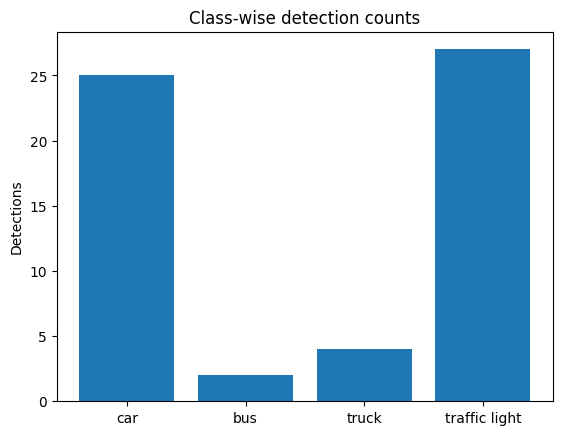

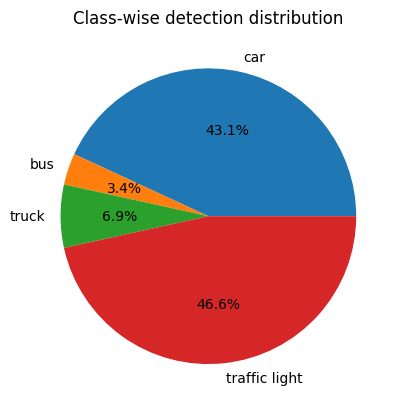

In [ ]:
# Multi-class comparison
from collections import Counter
import glob
import matplotlib.pyplot as plt


target_classes = ["car", "person", "bus", "truck", "motorcycle", "traffic light"]
name_to_id = {v:k for k,v in model.names.items()}

counts = Counter()

for img_file in glob.glob("extracted/Lab4/images/*.*"):
    results = model.predict(img_file, conf=0.51, iou=0.45, verbose=False)
    r = results[0]
    if r.boxes is None:
        continue
    cls_ids = r.boxes.cls.cpu().numpy().astype(int)
    for t in target_classes:
        if name_to_id[t] in cls_ids:
            counts[t] += (cls_ids == name_to_id[t]).sum()

# Bar chart
plt.bar(counts.keys(), counts.values())
plt.ylabel("Detections")
plt.title("Class-wise detection counts")
plt.show()

# Pie chart version
plt.pie(counts.values(), labels=counts.keys(), autopct="%1.1f%%")
plt.title("Class-wise detection distribution")
plt.show()


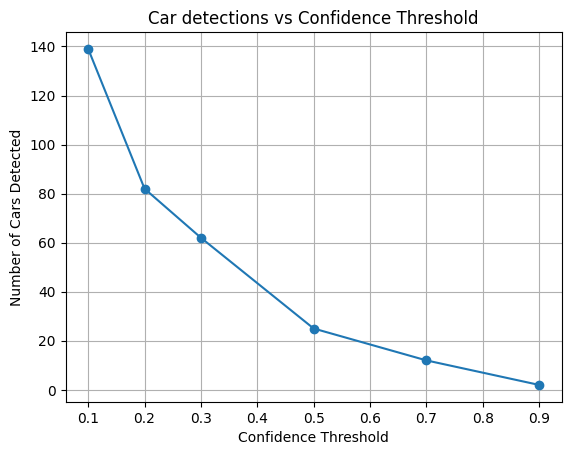

In [ ]:
conf_list = [0.1,0.2,0.3,0.5,0.7,0.9]
counts = []

for conf in conf_list:
    total = 0
    for img_file in glob.glob("extracted/Lab4/images/*.*"):
        boxes, scores, classes = run_yolov8(img_file, score_threshold=conf, iou_threshold=0.45)
        total += (classes == class_names.index("car")).sum()
    counts.append(total)

plt.plot(conf_list, counts, marker="o")
plt.xlabel("Confidence Threshold")
plt.ylabel("Number of Cars Detected")
plt.title("Car detections vs Confidence Threshold")
plt.grid(True)
plt.show()
